In [1]:
# Load package
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pymc as pm;import arviz as az; 
import math; import pandas as pd
from scipy.optimize import minimize
from scipy import special
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# Task 1: Another real dataset application of Jeffrey's prior

Replicate application in section 5.1 of 
He, D., Sun, D., & He, L. (2021). Objective Bayesian Analysis for the Student-t Linear Regression. Bayesian Analysis, 16(1). https://doi.org/10.1214/20-BA1198

In [2]:
# Load data
bond_data = pd.read_csv('4.csv')

# Predictor
x = bond_data['CouponRate']

# Outcome
true_y = bond_data['BidPrice']

# Sample size
n = 35

## Jeffrey prior

In [4]:
# Log probability of sigma prior: pdf = 1/x
def logsig(x):
    return -np.log(x)

# Jeffreys prior pdf
def logJeff(x):
    return pt.log((x/(x+3))**(1/2)*(pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

modelJeff_bond = pm.Model()

with modelJeff_bond:
    # Jeffrey's prior on nu
    nu = pm.CustomDist('nu', logp=logJeff)
    
    # sigma prior 1/x
    sigma = pm.CustomDist('sigma',logp=logsig)
    
    # Flat prior on betas
    intercept = pm.Flat('intercept')
    beta_1 = pm.Flat('beta_1')
    
    # Linear combination of beta and x
    mu = pm.Deterministic('mu', intercept + beta_1*x)

    # T regression likelihood
    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = n, observed = true_y)

    idataJeff_bond = pm.sample()

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, intercept, beta_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [5]:
# Posterior median
print("number of MCMC samples:", idataJeff_bond.posterior['nu'].values.flatten().shape[-1])
az.summary(idataJeff_bond,var_names=["nu","sigma","intercept","beta_1"], stat_focus="median", round_to=5)

number of MCMC samples: 4000


,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
nu,0.81950,0.15547,0.48799,1.41595,0.00881,1195.29391,732.86061,1.00379
sigma,0.46293,0.09990,0.23734,0.83084,0.00561,1260.45737,577.23631,1.00159
intercept,58.19978,1.01410,55.58726,60.79376,0.05531,990.31399,1398.33811,1.00037
beta_1,4.76453,0.10419,4.49213,5.02861,0.00569,994.83637,1380.79223,1.00038


## R2 prior

In [6]:
# Define R2 log probability
def sqrtdelta2(x):
    return (pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2)

def r2sigma(x):
    return pt.log(sqrtdelta2(x))


model_r2_bond = pm.Model()

with model_r2_bond:
    nu = pm.CustomDist('nu', logp=r2sigma, initval = 1)
    
    sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
    
    intercept = pm.Flat('intercept')
    beta_1 = pm.Flat('beta_1')
    
    mu = pm.Deterministic('mu', intercept + beta_1*x)

    ### Changed to a T distribution ###
    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = n, observed = true_y)

    idata_r2_bond = pm.sample()

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, intercept, beta_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [7]:
# Posterior median
print("number of MCMC samples:", idata_r2_bond.posterior['nu'].values.flatten().shape[-1])
az.summary(idata_r2_bond,var_names=["nu","sigma","intercept","beta_1"], stat_focus="median", round_to=2)

number of MCMC samples: 4000


,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
nu,0.80,0.15,0.47,1.33,0.01,1422.76,1677.12,1.0
sigma,0.45,0.10,0.22,0.80,0.00,1378.69,760.27,1.0
intercept,58.06,0.94,55.63,60.69,0.06,1252.43,1807.68,1.0
beta_1,4.78,0.10,4.50,5.02,0.01,1264.46,1852.88,1.0


In [14]:
# All close to paper results.
# probably something wrong with paper 1

# Task 2: Simulations with Jeffreys marginal prior (corrected)

In [2]:
def generate_Corr_identity(p):
    Sigma = np.zeros((p-1, p-1))
    np.fill_diagonal(Sigma, 1)
    return Sigma

def generate_data(n, p, sigma_sqr, beta, nu, corr):

    beta = beta.reshape((p, 1))
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    x_i_full =  np.concatenate((ones, x_i_correlated), axis=1)
    XB = x_i_full @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y, x_i_full

In [3]:
# Generate Data
p = 5
beta = np.array([2, 1, 0.3, 0.9, 1])
n = 30
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  # You need to define this function
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

In [5]:
# Log likelihood function to be optimized
def get_beta_sigma(params, nu):
    beta1, beta2, beta3, beta4, beta5, sigma = params
    XB = beta1*X[:, 0] + beta2*X[:, 1] + beta3*X[:, 2] + beta4*X[:, 3] + beta5*X[:, 4]
    n = X.shape[0]
    XB = XB.reshape((n, 1))

    # loglikelihood
    equation = n * np.log(pt.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(pt.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -equation

def optimize_over_nu(nu):
    p = X.shape[1]
    bounds = [(None, None)] * p +[(0, np.inf)]
    initial_guess = np.random.normal(0, 1, size = (p+1))
    result = minimize(get_beta_sigma, initial_guess, args=(nu), method='Nelder-Mead',bounds= bounds)

    return result.x# Return the optimized parameters 

from pytensor.tensor import TensorVariable
def logJeff(x)-> TensorVariable:
    return pt.log((x/(x+3))**(1/2)*(pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))


In [39]:
modelJeff_MLE = pm.Model()

with modelJeff_MLE:
    nu = pm.CustomDist('nu', logp=logJeff, initval = 2)
    
    intercept = pm.Deterministic("intercept",optimize_over_nu(nu)[0])
    beta_1 = pm.Deterministic("beta_1",optimize_over_nu(nu)[1])
    beta_2 = pm.Deterministic("beta_2",optimize_over_nu(nu)[2])
    beta_3 = pm.Deterministic("beta_3",optimize_over_nu(nu)[3])
    beta_4 = pm.Deterministic("beta_4",optimize_over_nu(nu)[4])
   
    mu = pm.Deterministic('mu',intercept*X[:, 0] + beta_1*X[:, 1] + beta_2*X[:, 2] + beta_3*X[:, 3] + beta_4*X[:, 4])
    
    sigma = pm.Deterministic("sigma",optimize_over_nu(nu)[5])

    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = 100, observed = true_Y)

    idataJeff_MLE = pm.sample()

TypeError: _tensor_py_operators.sum() got an unexpected keyword argument 'out'

# Task 3i: Reference prior on real dataset
Using dataset from section 5 from O. Fonseca, T. C., R. Ferreira, M. A., & Migon, H. S. (2014). Objective Bayesian analysis for the Student-t regression model. Biometrika, 101(1), 252–252. https://doi.org/10.1093/biomet/asu001

In [8]:
# Load data
data = pd.read_csv('PublicSchools.csv')

# Extract data in vector form

# Predictors
X1 = data['Income'] # Linear 
X2 = data['Income']^(2) # Quadratic

# Outcome
true_Y = data['Expenditure']
# Sample size = 50
n = 50

In [9]:
# Define square root delta functions

def sqrtdelta1(x):
    return (pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+5)/(x*(x+1)*(x+3)))**(1/2)

def sqrtdelta2(x):
    return (pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2)

# Log probability functions
def logJeff(x):
    return pt.log((x/(x+3))**(1/2)*(pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

def logsig(x):
    return -np.log(x)


In [10]:
modelJeff_quad = pm.Model()

with modelJeff_quad:
    # Jeffrey's prior on nu
    nu = pm.CustomDist('nu', logp=logJeff, initval = 1)
    
    # sigma prior 1/x
    sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
    
    # Flat prior on betas
    intercept = pm.Flat('intercept')
    beta_1 = pm.Flat('beta_1')
    beta_2 = pm.Flat('beta_2')
    
    # Linear combination of beta and x
    mu = pm.Deterministic('mu', intercept + beta_1*X1 + beta_2*X2)

    # T regression likelihood
    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = n, observed = true_Y)

    idataJeff_quad = pm.sample()

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, intercept, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 304 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [11]:
## 1. R1

def r1sigma(x):
    return pt.log(sqrtdelta1(x))


model_r1 = pm.Model()

with model_r1:
    nu = pm.CustomDist('nu', logp=r1sigma, initval = 1)
    
    sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
    
    intercept = pm.Flat('intercept')
    beta_1 = pm.Flat('beta_1')
    beta_2 = pm.Flat('beta_2')
    
    mu = pm.Deterministic('mu', intercept + beta_1*X1 + beta_2*X2)

    ### Changed to a T distribution ###
    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = n, observed = true_Y)

    idata_r1 = pm.sample()

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, intercept, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 309 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [12]:
## 2. R2

def r2sigma(x):
    return pt.log(sqrtdelta2(x))


model_r2 = pm.Model()

with model_r2:
    nu = pm.CustomDist('nu', logp=r2sigma, initval = 1)
    
    sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
    
    intercept = pm.Flat('intercept')
    beta_1 = pm.Flat('beta_1')
    beta_2 = pm.Flat('beta_2')
    
    mu = pm.Deterministic('mu', intercept + beta_1*X1 + beta_2*X2)

    ### Changed to a T distribution ###
    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = n, observed = true_Y)

    idata_r2 = pm.sample()

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, intercept, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 296 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [13]:
## 3. R3

p = 2

def r3sigma(x):
    return pt.log(((x+1)/(x+3))**(p/2)*sqrtdelta1(x))


model_r3 = pm.Model()

with model_r3:
    nu = pm.CustomDist('nu', logp=r3sigma, initval = 1)
    
    sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
    
    intercept = pm.Flat('intercept')
    beta_1 = pm.Flat('beta_1')
    beta_2 = pm.Flat('beta_2')
    
    mu = pm.Deterministic('mu', intercept + beta_1*X1 + beta_2*X2)

    ### Changed to a T distribution ###
    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = n, observed = true_Y)

    idata_r3 = pm.sample()

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, intercept, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 305 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [14]:
## 4. R4

p = 2

def r4sigma(x):
    return pt.log(((x+1)/(x+3))**(p/2)*sqrtdelta2(x))


model_r4 = pm.Model()

with model_r4:
    nu = pm.CustomDist('nu', logp=r4sigma, initval = 1)
    
    sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
    
    intercept = pm.Flat('intercept')
    beta_1 = pm.Flat('beta_1')
    beta_2 = pm.Flat('beta_2')
    
    mu = pm.Deterministic('mu', intercept + beta_1*X1 + beta_2*X2)

    ### Changed to a T distribution ###
    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = n, observed = true_Y)

    idata_r4 = pm.sample()

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, intercept, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 309 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [15]:
## 5. R5

p = 5

def psigma(x):
    return -(p+1)*np.log(x)

model_r5 = pm.Model()

with model_r5:
    nu = pm.CustomDist('nu', logp=r2sigma, initval = 1)
    
    sigma = pm.CustomDist('sigma',logp=psigma, initval = 1)
    
    intercept = pm.Flat('intercept')
    beta_1 = pm.Flat('beta_1')
    beta_2 = pm.Flat('beta_2')
    
    mu = pm.Deterministic('mu', intercept + beta_1*X1 + beta_2*X2)

    ### Changed to a T distribution ###
    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = n, observed = true_Y)

    idata_r5 = pm.sample()

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, intercept, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 302 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [16]:
## 6. R6

p = 2

model_r6 = pm.Model()

with model_r6:
    nu = pm.CustomDist('nu', logp=r1sigma, initval = 1)
    
    sigma = pm.CustomDist('sigma',logp=psigma, initval = 1)
    
    intercept = pm.Flat('intercept')
    beta_1 = pm.Flat('beta_1')
    beta_2 = pm.Flat('beta_2')
    
    mu = pm.Deterministic('mu', intercept + beta_1*X1 + beta_2*X2)

    ### Changed to a T distribution ###
    y = pm.StudentT('y', nu = nu, mu = mu, sigma = sigma, shape = n, observed = true_Y)

    idata_r6 = pm.sample()

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, intercept, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 294 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


## Posterior median

In [17]:
az.summary(idata_r1.posterior['nu'], stat_focus="median", round_to=2)

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
nu,3.18,0.9,1.64,14.23,0.48,11.13,12.2,1.58


In [18]:
az.summary(idata_r2.posterior['nu'], stat_focus="median", round_to=2)

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
nu,4.85,1.59,2.3,9.93,1.71,5.45,11.94,2.32


In [19]:
az.summary(idata_r3.posterior['nu'], stat_focus="median", round_to=2)

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
nu,4.47,0.95,1.77,12.6,0.31,11.66,19.02,1.79


In [20]:
az.summary(idata_r4.posterior['nu'], stat_focus="median", round_to=2)

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
nu,5.0,1.78,1.94,23.17,0.43,67.51,20.06,1.07


In [21]:
az.summary(idata_r5.posterior['nu'], stat_focus="median", round_to=2)

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
nu,2.34,0.94,0.17,4.93,0.55,8.56,15.34,1.78


In [22]:
az.summary(idata_r6.posterior['nu'], stat_focus="median", round_to=2)

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
nu,2.86,1.71,0.23,7.82,0.35,5.71,25.41,2.39


In [23]:
az.summary(idataJeff_quad.posterior['nu'], stat_focus="median", round_to=2)

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
nu,3.38,1.02,1.78,13.94,0.65,11.07,40.02,1.38


# Task 3ii: More betas (early attempt of high dim)

In [33]:
def generate_Corr_identity(p):
    Sigma = np.zeros((p-1, p-1))
    np.fill_diagonal(Sigma, 1)
    return Sigma

def generate_data(n, p, sigma_sqr, beta, nu, corr):

    beta = beta.reshape((p, 1))
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    x_i_full =  np.concatenate((ones, x_i_correlated), axis=1)
    XB = x_i_full @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y, x_i_full

def logsig(x):
    return -np.log(x)

def logJeff(x):
    return pt.log((x/(x+3))**(1/2)*(pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

def calculate_y_axix(nu_origin, nu_est):
    n = len(nu_est)
    nu_origin_vec = nu_origin * np.ones((n, 1))
    mse = np.sum((nu_est - nu_origin_vec)**2) / n
    result = np.sqrt(mse)/nu_origin
    return result

## n > p

In [34]:
# Fix true nu
nu_origin = 5 

# Fix number of observations
n = 100

# A range of dimensions/predictors
dim_list = []
        
# Number of simulations
num_sim = 5
result_value_mse_Jeff = []
    
# Generate data for different dim       
for dim in range(10, 91, 10): ## loop for high dim predictors 
    dim_list.append(dim)
    p = dim
    beta = stats.norm.rvs(size=p)
    sigma_sqr = 1.5

# Run multiple simulations for fixed dim
    for i in range(num_sim): 
        corr = generate_Corr_identity(p)  
        y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr) ## Generate data
        est_nu_jeff = np.ones((num_sim, 1))
        
        with pm.Model() as modelJeff_high_dim: ## Jeff model
            nu = pm.CustomDist('nu', logp=logJeff, initval = 1)
            sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
            betas = pm.Flat('betas', shape = (p,1))
            y = pm.StudentT('y', nu = nu, mu = pm.math.dot(X, betas), sigma = sigma, shape = (n,1), observed = y)
            idataJeff_high_dim = pm.sample() 
            est_nu = np.median(idataJeff_high_dim.posterior['nu']) ## Posterior median for a simulation
            est_nu_jeff[i] = est_nu ## Store all posterior medians of same dim in a list

    # record averaged MSE for each dim
    value_mse_Jeff = calculate_y_axix(nu_origin, est_nu_jeff)
    result_value_mse_Jeff.append(value_mse_Jeff) ## Store MSE for each dim in a list

df = pd.DataFrame({'dim': dim_list,
                        'MSE Jeff': result_value_mse_Jeff,
                        })

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 213 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1205 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 595 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 919 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 757 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 667 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1082 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 760 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1429 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 340 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1228 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pro

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 985 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 549 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 594 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 982 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 629 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 387 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 621 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 695 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 353 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1027 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 171 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 754 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-pack

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1145 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1885 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1224 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1016 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 860 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 852 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 174 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1507 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 769 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 813 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 754 divergences after tuning. Increase `target_accept` or reparameterize.


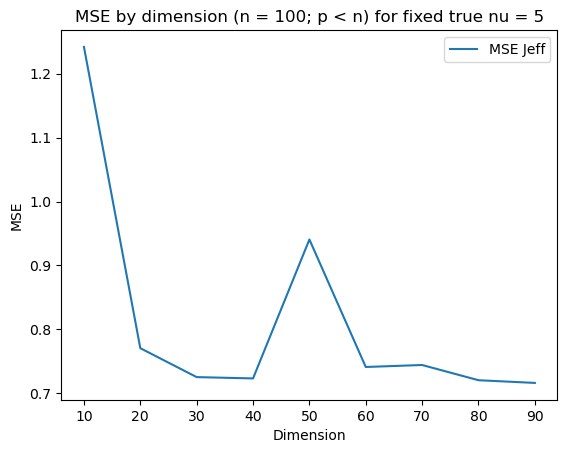

In [35]:
# Plot MSE vs dim 

# Plotting
plt.plot(df['dim'], df['MSE Jeff'], label='MSE Jeff')
# Adding labels and legend
plt.xlabel('Dimension')
plt.ylabel('MSE')
plt.title('MSE by dimension (n = 100; p < n) for fixed true nu = '+ str(nu_origin))
plt.legend()
# Showing the plot
plt.show()

In [ ]:
# num of sim and higher dim computational cost

# Task 4: adjusted profile likelihood in simulations

## MLE based on adjusted loglik.

In [3]:
def generate_Corr_identity(p):
    Sigma = np.zeros((p-1, p-1))
    np.fill_diagonal(Sigma, 1)
    return Sigma

def generate_data(n, p, sigma_sqr, beta, nu, corr):

    beta = beta.reshape((p, 1))
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    x_i_full =  np.concatenate((ones, x_i_correlated), axis=1)
    XB = x_i_full @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y, x_i_full

# Generate Data
p = 5 #number of betas
beta = np.array([20, 10, 30, 90, 15])
n = 300
nu_origin = 100
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

### Step 0: Obtain the expression for the log-likelihood

In [4]:
def negative_log_likelihood_optimize_beta_sigma(params, nu):
    """
    Negative log likelihood that will be passed into minimize function for given nu
    The use of it is to get the numerical result of beta and sigma
    :param params: contains beta and sigma as one vector, dim = p + 1
    :param nu: Degree of freedom
    :param X: Data matrix
    :param y: Observed Value
    :return: The negative log likelihood equation (2) in Fonseca 2008
    """

    betas, sigma = params[:-1], params[-1]
    if sigma <= 0:
        return np.inf  # Return infinity if sigma is non-positive
    p = X.shape[1]
    B = np.reshape(betas, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    # loglikelihood
    equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -equation

### Step 1: Compute the conditional MLE λ for each fixed ν

In [5]:
def optimize_over_nu(nu):
    p = X.shape[1]
    bounds = [(None, None)] * p +[(0, np.inf)]
    initial_guess = np.random.normal(0, 1, size = (p+1))
    initial_guess[p] = np.abs(initial_guess[p])
    result = minimize(negative_log_likelihood_optimize_beta_sigma, initial_guess, args=(nu,), method='Nelder-Mead',bounds= bounds)

    return result.x# Return the optimized parameters

In [6]:
def profile_loglikelihood(nu):
    #beta1 = optimize_over_nu(nu)[0]
    #beta2 = optimize_over_nu(nu)[1]
    #beta3 = optimize_over_nu(nu)[2]
    #beta4 = optimize_over_nu(nu)[3]
    #beta5 = optimize_over_nu(nu)[4]
    sigma = optimize_over_nu(nu)[5]
    beta = optimize_over_nu(nu)[0:5]
    
    B = np.reshape(beta, (p, 1))
    XB = X @ B

    #XB = beta1*X[:, 0] + beta2*X[:, 1] + beta3*X[:, 2] + beta4*X[:, 3] + beta5*X[:, 4]
    n = X.shape[0]
    XB = XB.reshape((n, 1))

    eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -eqt

In [7]:
# Grid search
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_loglikelihood_list.append(profile_loglikelihood(nu))
    DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


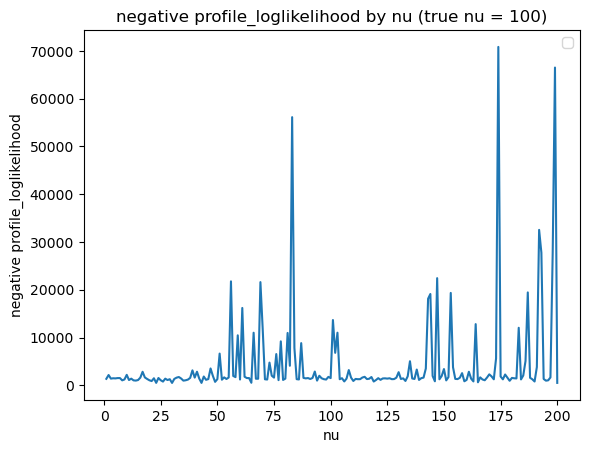

In [8]:
# Plotting
plt.plot(DF['nu'], DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative profile_loglikelihood')
plt.title('negative profile_loglikelihood by nu (true nu = 100)')
plt.legend()
# Showing the plot
plt.show()

In [ ]:
# trapped at local max/min
# check the eqt again
# try step = 0.1

### Step 2: Compute the observed Fisher information matrix

In [27]:
def Hess_beta_sigma(beta, sigma, nu, X, y):
    """
    The Hessian matrix of the log likelihood function
    :param beta: Coefficients
    :param sigma: Scale
    :param nu: Degree of freedom
    :param X: Data Matrix
    :param y: Observed Value
    :return: Hessian Matrix of beta and sigma on the log likelihood function, equation (2) Fonseca 2008
    """
    p = X.shape[1]
    n = X.shape[0]
    beta = np.array(beta)
    sigma = np.array(sigma)
    total_b2 = 0
    total_b_sigma = 0
    total_sigma_b = 0
    total_s2 = 0
    for i in range(n):
        Xi = np.reshape(X[i,:], (p, 1))
        residual = y[i] - X[i, :] @ beta
        nu_sigma_sqr_plus_residual =  nu*(sigma**2)+ residual**2
        total_b2 = total_b2 + (- (nu_sigma_sqr_plus_residual)* np.outer(X[i,:],X[i, :]) + np.outer(X[i, :], X[i, :])*2*(residual**2))/(nu_sigma_sqr_plus_residual**2)
        total_b_sigma = total_b_sigma + (- nu_sigma_sqr_plus_residual*2 * residual * X[i,:] + 2*(residual**3 )*X[i,:]) / (nu_sigma_sqr_plus_residual**2)
        total_sigma_b = total_sigma_b + (-2*nu*sigma*X[i,:]*residual)/(nu_sigma_sqr_plus_residual**2)
        total_s2 = total_s2+ (-(residual**2) * 2* nu ) / ( (nu_sigma_sqr_plus_residual**2)) - 2*(residual**2)/(nu_sigma_sqr_plus_residual* (sigma**2))

    db2 = total_b2 * (nu+1)
    dbs = total_b_sigma * (nu+1)/sigma
    dsb = total_sigma_b * (nu+1)
    ds2 = n/(sigma**2) + (nu+1)*total_s2

    hessian = np.zeros((p + 1, p + 1))
    hessian[:p, :p] = db2
    hessian[:p, p] = dbs
    hessian[p, :p] = dsb
    hessian[p, p] = ds2

    return hessian

### Step 3: Find the block of j(ν, λ) corresponding to the insurance parameters λ = (β, σ).

In [28]:
def obs_block_det(beta, sigma, nu, X, y):
    
    block = np.array(Hess_beta_sigma(beta, sigma, nu, X, y))* -1
    
    return np.linalg.det(block)

### Step 4: Plug λˆν you found in Step 1 to the block matrix j(ν, λ) in Step 4, to get j(ν, λˆ ν).

### Step 5: Adjusted profile log-likelihood function

In [29]:
def adj_profile_loglikelihood(nu):
    #beta1 = optimize_over_nu(nu)[0]
    #beta2 = optimize_over_nu(nu)[1]
    #beta3 = optimize_over_nu(nu)[2]
    #beta4 = optimize_over_nu(nu)[3]
    #beta5 = optimize_over_nu(nu)[4]
    sigma = optimize_over_nu(nu)[5]
    beta = optimize_over_nu(nu)[0:5]
    
    B = np.reshape(beta, (p, 1))
    XB = X @ B

    #XB = beta1*X[:, 0] + beta2*X[:, 1] + beta3*X[:, 2] + beta4*X[:, 3] + beta5*X[:, 4]
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    det = obs_block_det(beta, sigma, nu, X, y)

    adj_eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))-0.5*np.log(abs(det)) 
    return -adj_eqt

In [30]:
# Non converging
minimize(adj_profile_loglikelihood,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 492.83720736867417
             x: [ 1.059e+02]
           nit: 75
          nfev: 200
 final_simplex: (array([[ 1.059e+02],
                       [ 1.059e+02]]), array([ 4.928e+02,  1.209e+03]))

In [31]:
# Grid search
nu_list =[]
adj_profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_loglikelihood_list.append(adj_profile_loglikelihood(nu))
    DF = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_loglikelihood_list,
                        })

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


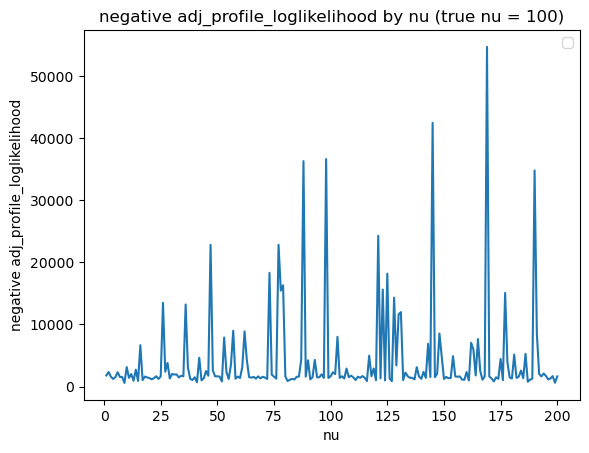

In [32]:
# Plotting
plt.plot(DF['nu'], DF['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative adj_profile_loglikelihood')
plt.title('negative adj_profile_loglikelihood by nu (true nu = 100)')
plt.legend()
# Showing the plot
plt.show()